In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp

from src.rsbp.problem import RSBP, EntropicRSBP
from src.rsbp.sinkhorn import calc_U, robust_ibp_eps
from src.utils import norm_inf, calc_KL

import time

In [2]:
# Dimension
n = 10
m = 5

# Regularization
tau = np.float64(1.0)

In [3]:
np.random.seed(3698)

# Cost matrix
C = np.random.uniform(low=0.01, high=0.1, size=(m, n, n)).astype(np.float64)

# Marginal vectors
p = np.random.rand(m, n).astype(np.float64)
p = p / p.sum(1, keepdims=True)

# weight
w = np.random.rand(m).astype(np.float64)
w = w / w.sum()

Original RSBP problem

In [4]:
# Original RSBP
rsbp = RSBP(C, p, w, tau)

In [5]:
# Optimal solution for RSBP
X_hat = rsbp.optimize_f()

f_hat = rsbp.calc_f(X_hat)

print('Optimal:', f_hat)

Optimal: 0.025202882163284236


Entropic regularized RSBP

In [6]:
# Entropic regularization parameter
eta = np.float64(0.001)

# Convert to Entropic Regularized ROT
ersbp = rsbp.entropic_regularize(eta)

Optimal solution for the primal **without** the normalization constraint

In [7]:
# Optimal solution for EntropicRSBP
X_star_hat = ersbp.optimize_g(with_norm_constraint=False)

f_star_hat = ersbp.calc_f(X_star_hat)
g_star_hat = ersbp.calc_g(X_star_hat)

print(X_star_hat.sum((1, 2)))
print('Optimal:', f_star_hat, g_star_hat)

[0.97661459 0.97661459 0.97661459 0.97661459 0.97661459]
Optimal: 0.024971786313553034 0.021432183140740548


Optimal solution for the primal **with** the normalization constraint

In [8]:
# Optimal solution for EntropicRSBP
X_star = ersbp.optimize_g(with_norm_constraint=True)

f_star = ersbp.calc_f(X_star)
g_star = ersbp.calc_g(X_star)

print(X_star.sum((1, 2)))
print('Optimal:', f_star, g_star)

[1. 1. 1. 1. 1.]
Optimal: 0.025287550052336502 0.021686853271507017


$$
    X_i^* = \dfrac{\bar{X_i^*}}{||\bar{X_i^*}||_1}, \forall i \in [m]
$$

In [9]:
norm_inf(X_star_hat / X_star_hat.sum((1, 2), keepdims=True)  - X_star)

1.3591209699348461e-08

In [10]:
u_star, v_star = ersbp.optimize_h()
X_star_dual = ersbp.calc_B(u_star, v_star)

f_star_dual = ersbp.calc_f(X_star_dual)
g_star_dual = ersbp.calc_g(X_star_dual)
h_star_dual = ersbp.calc_h(u_star, v_star)

print(X_star_hat.sum((1, 2)))
print('Optimal:', f_star_dual, g_star_dual, h_star_dual)

[0.97661459 0.97661459 0.97661459 0.97661459 0.97661459]
Optimal: 2.497385842112317e-02 0.021431694935935865 0.9775680501657995


In [11]:
norm_inf(X_star_dual  - X_star)

0.003553627972598755

In [12]:
norm_inf(X_star_dual / X_star_dual.sum((1, 2), keepdims=True)  - X_star)

4.7599449798374494e-08

Solve with Sinkhorn iterations

In [13]:
eps = 0.0001

# Entropic regularization parameter
U = calc_U(rsbp, eps)
eta = eps / U

# Convert to Entropic Regularized UOT
ersbp = rsbp.entropic_regularize(eta)

In [14]:
print(f'Epsilon:', eps)
start = time.time()

# Sinkhorn
_, log = robust_ibp_eps(ersbp, f_hat, eps, 
                        patience=1000, verbose=True)

print('Time elapsed:', time.time() - start)

Epsilon: 0.0001
0 2.2486936819316545e+00
1000 5.685780046965152e-02
2000 4.707621964406292e-02
3000 2.6600456187623238e-02
4000 2.6551774002233405e-02
5000 2.6456282096694313e-02
6000 2.6380490025453063e-02
7000 2.535580202914118e-02
8000 2.5319206034852864e-02
9000 2.531893683887245e-02
10000 2.5282687482429216e-02
10098 2.5282687469526006e-02
(10099, 5, 10)
Time elapsed: 2.7709784507751465


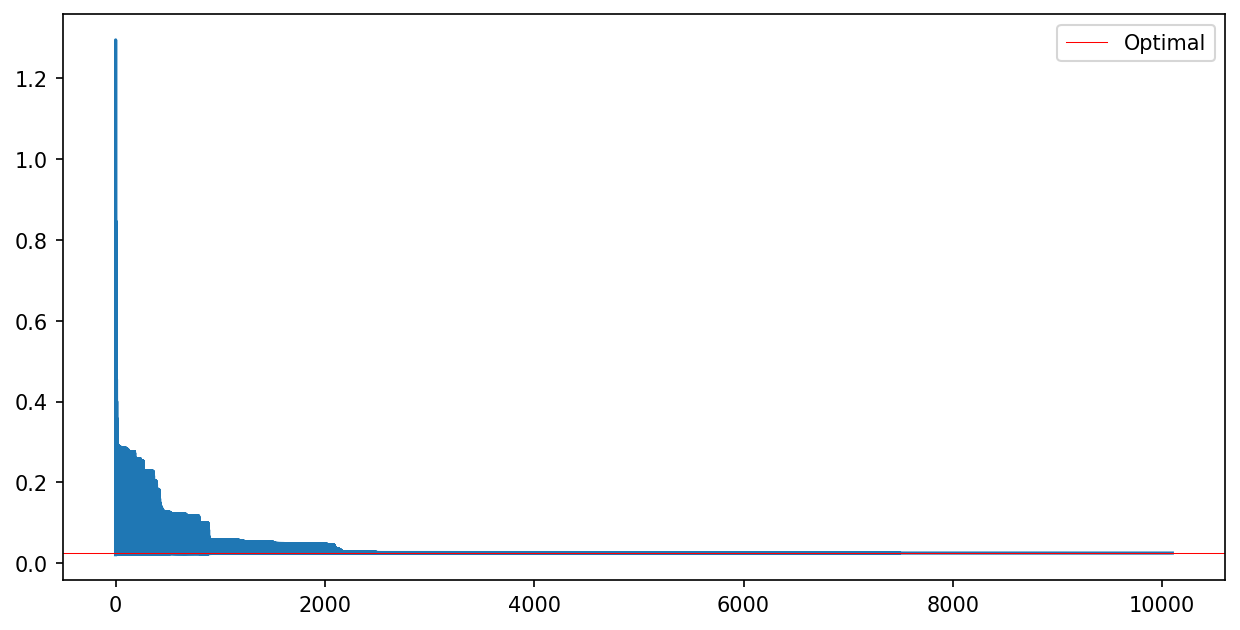

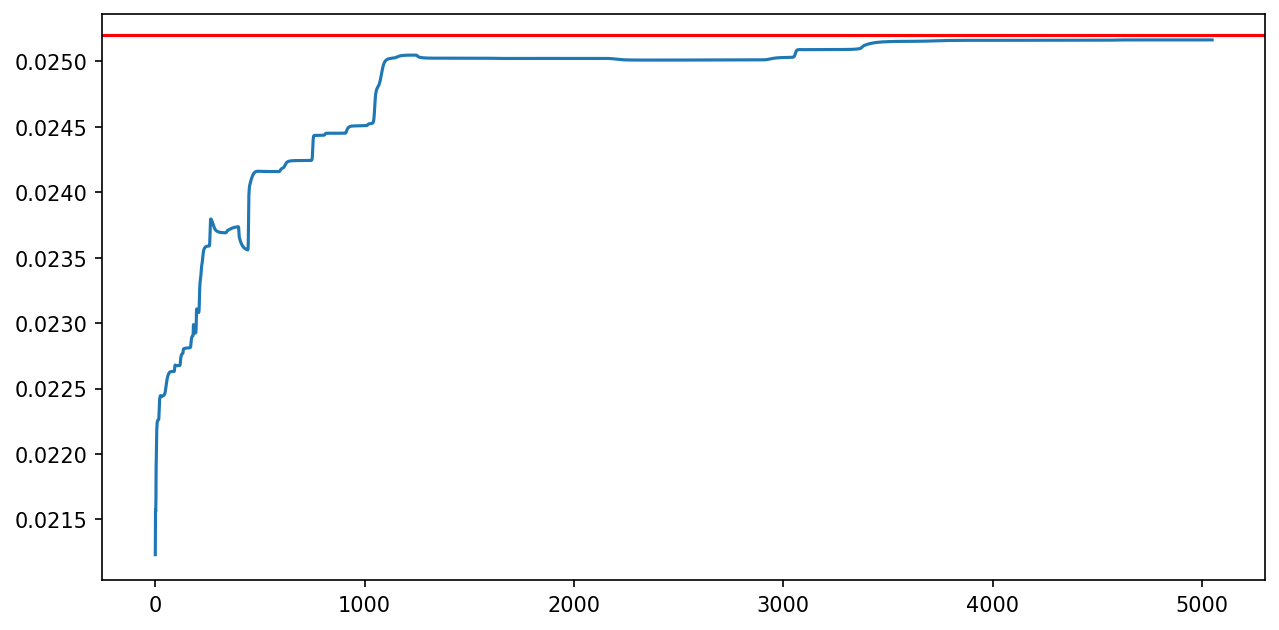

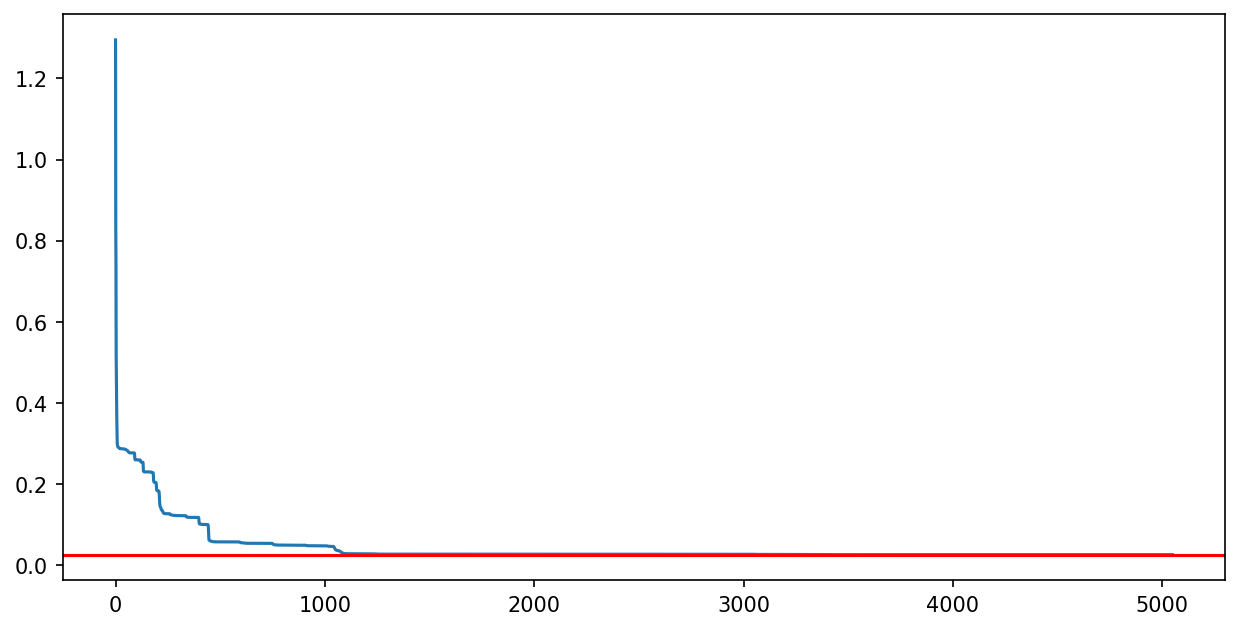

In [15]:
# Overview
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(log['f'][1:])
plt.axhline(f_hat, color='red', label='Optimal', linewidth=0.5)
plt.legend()
plt.show()

# After u update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(log['f'][1::2])
plt.axhline(f_hat, color='red')
plt.show()

# After v update
plt.figure(figsize=(10, 5), dpi=150)
plt.plot(log['f'][2::2])
plt.axhline(f_hat, color='red')
plt.show()

0


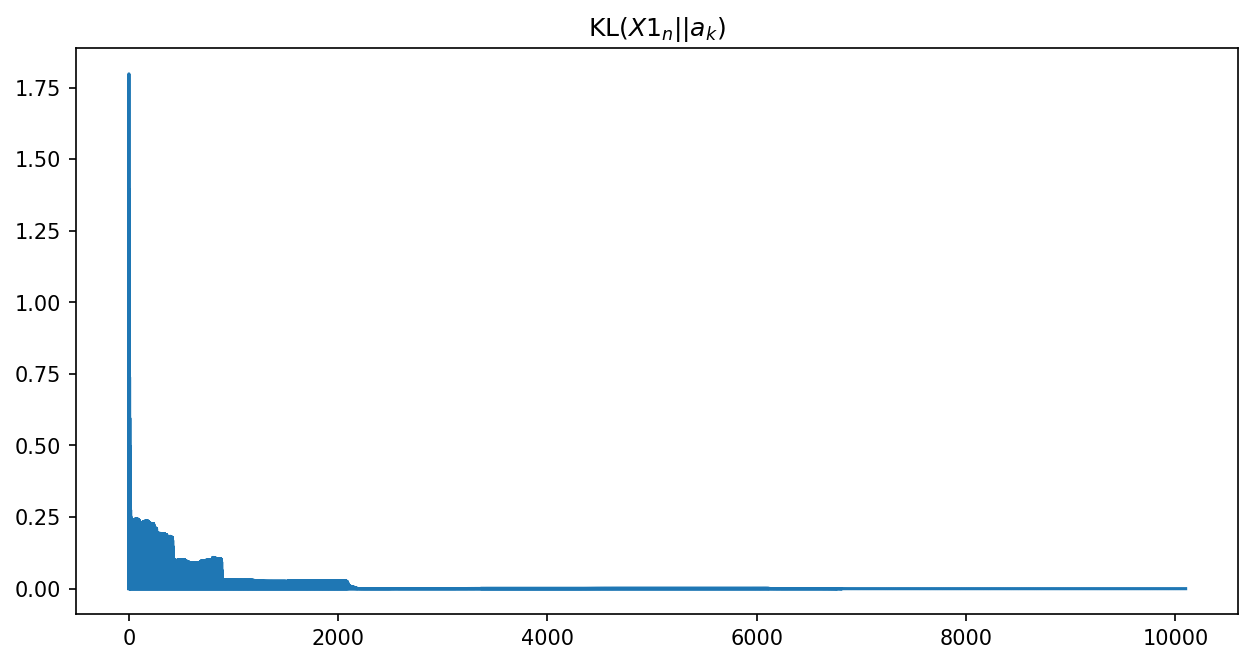

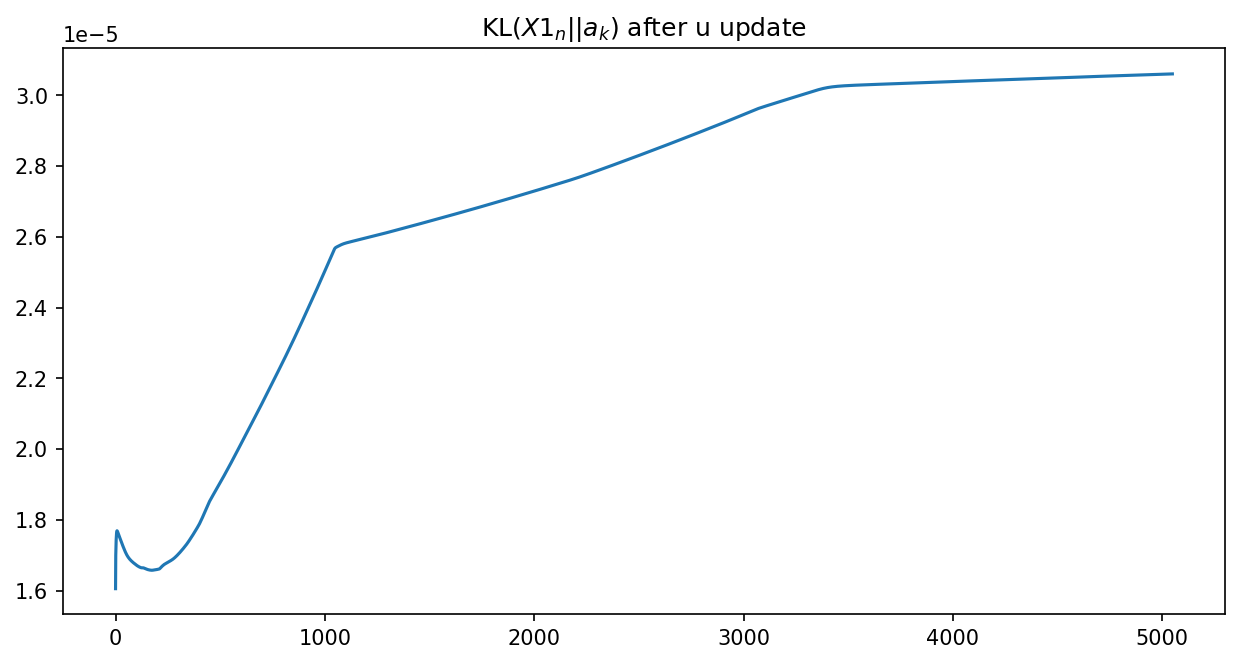

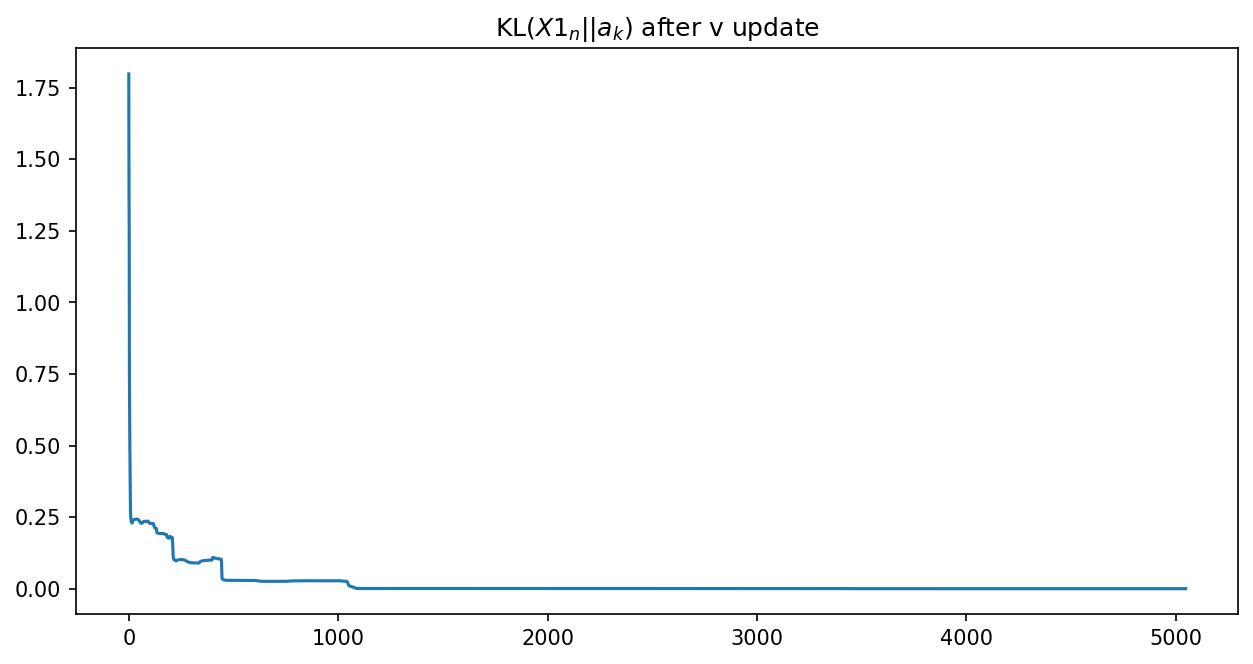

1


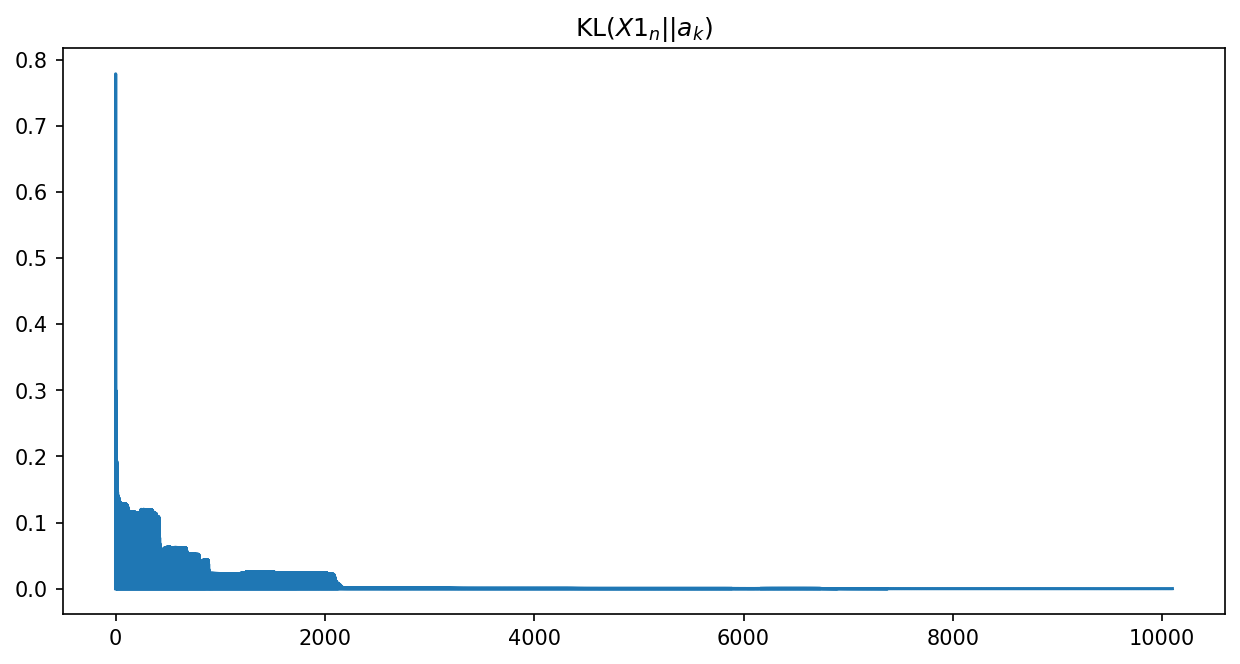

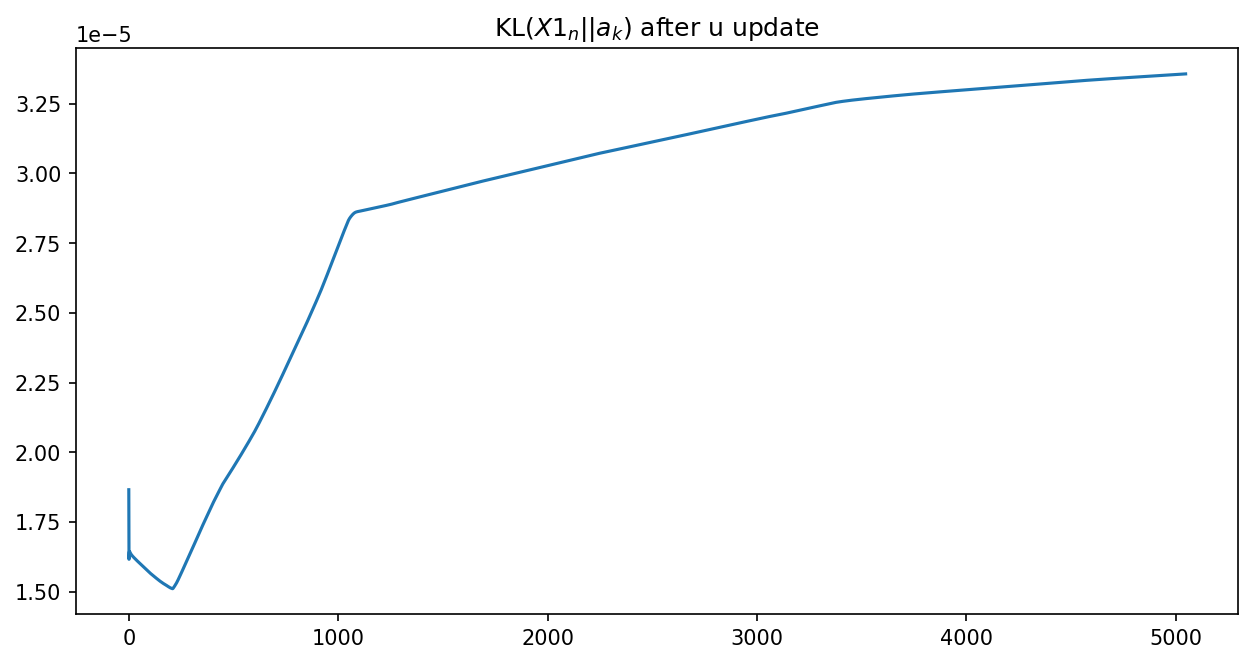

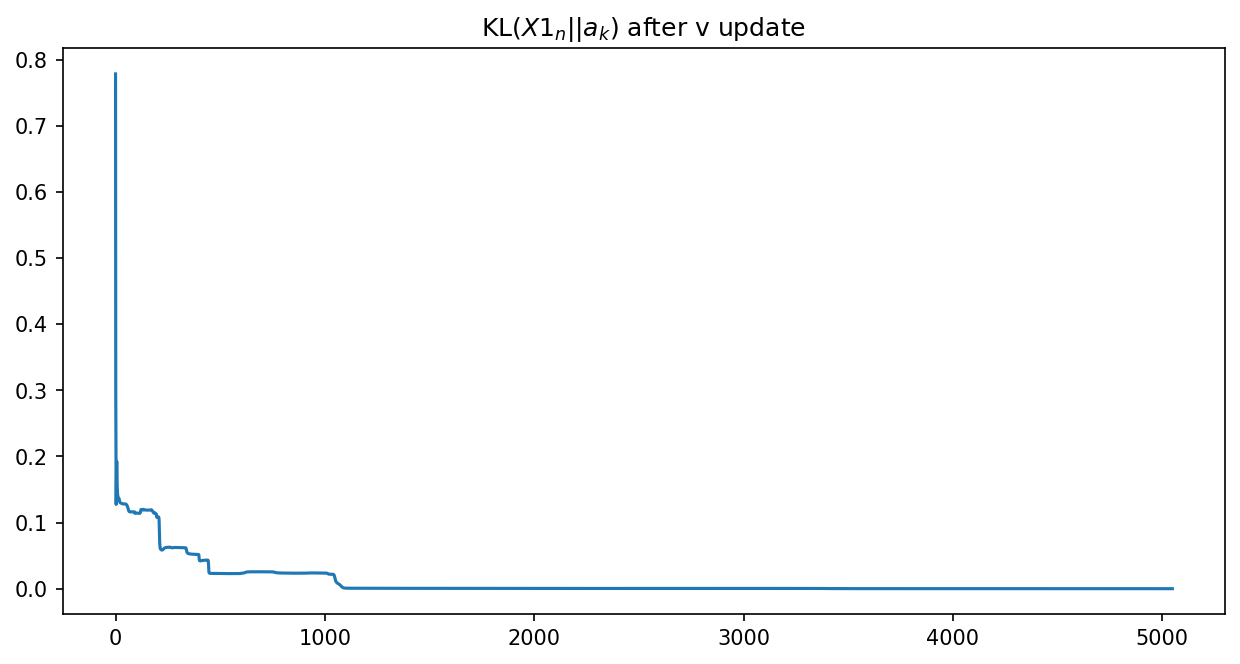

2


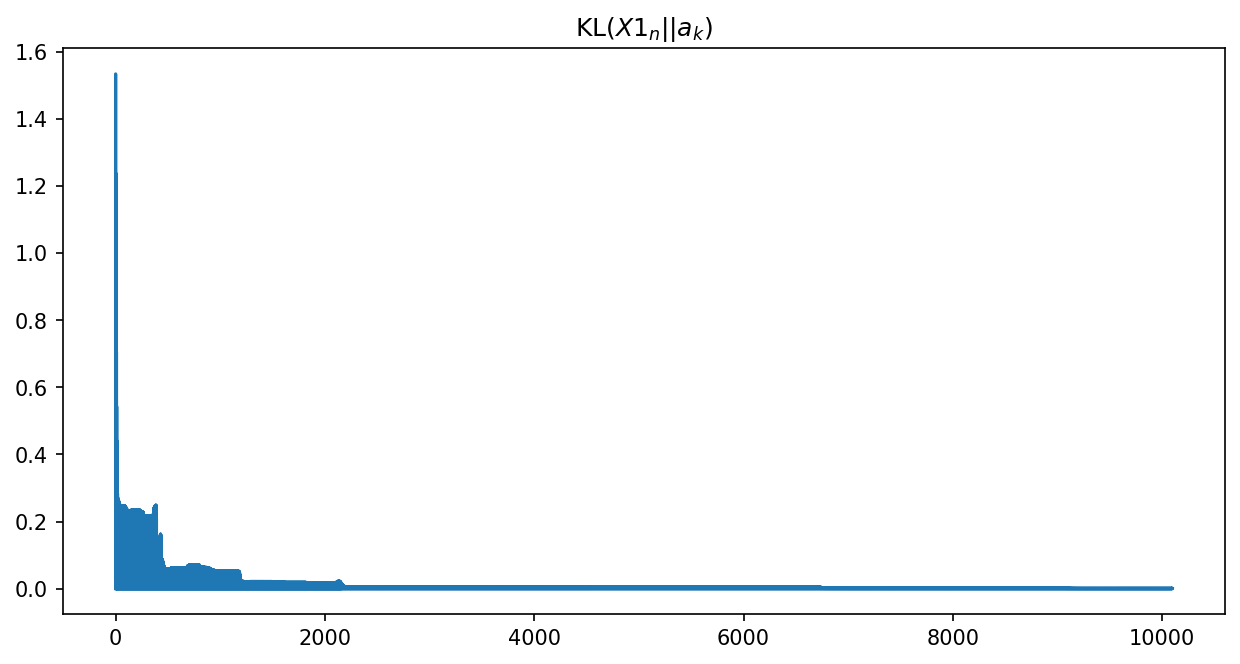

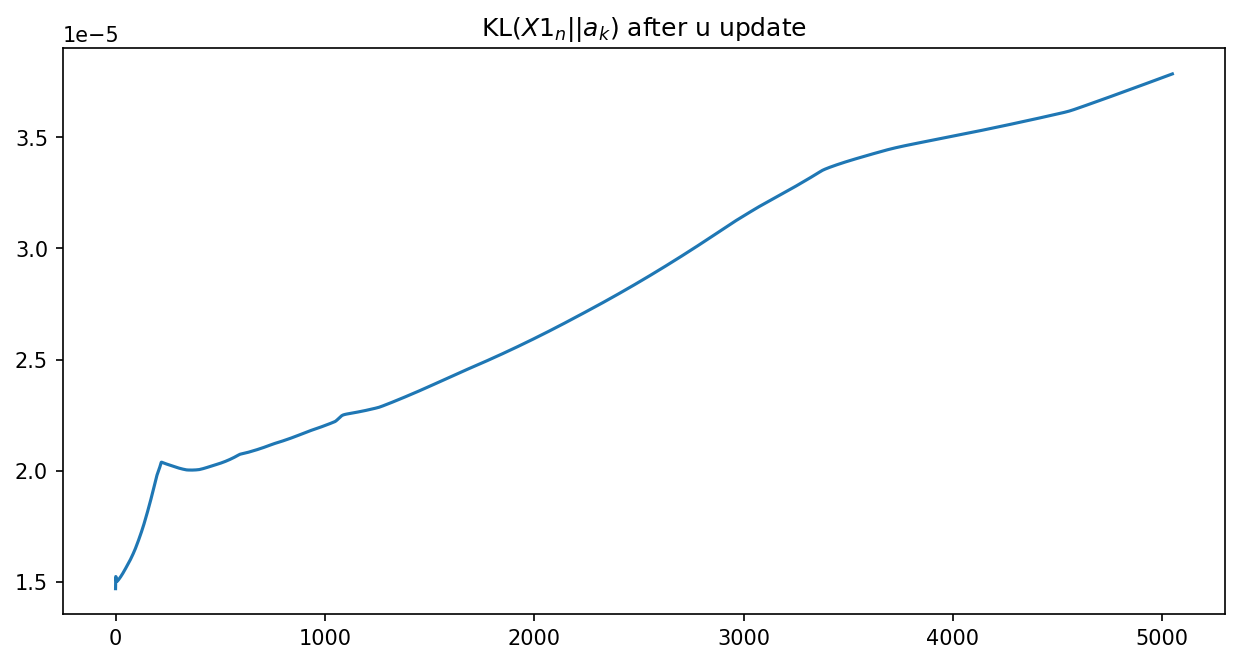

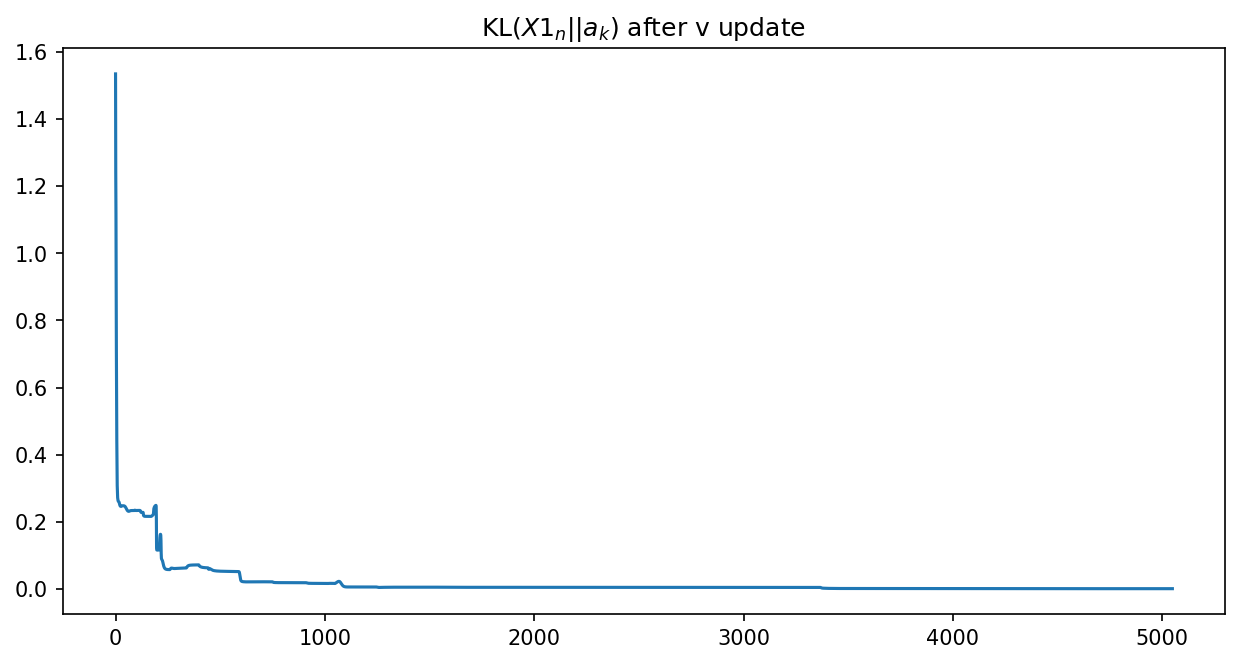

3


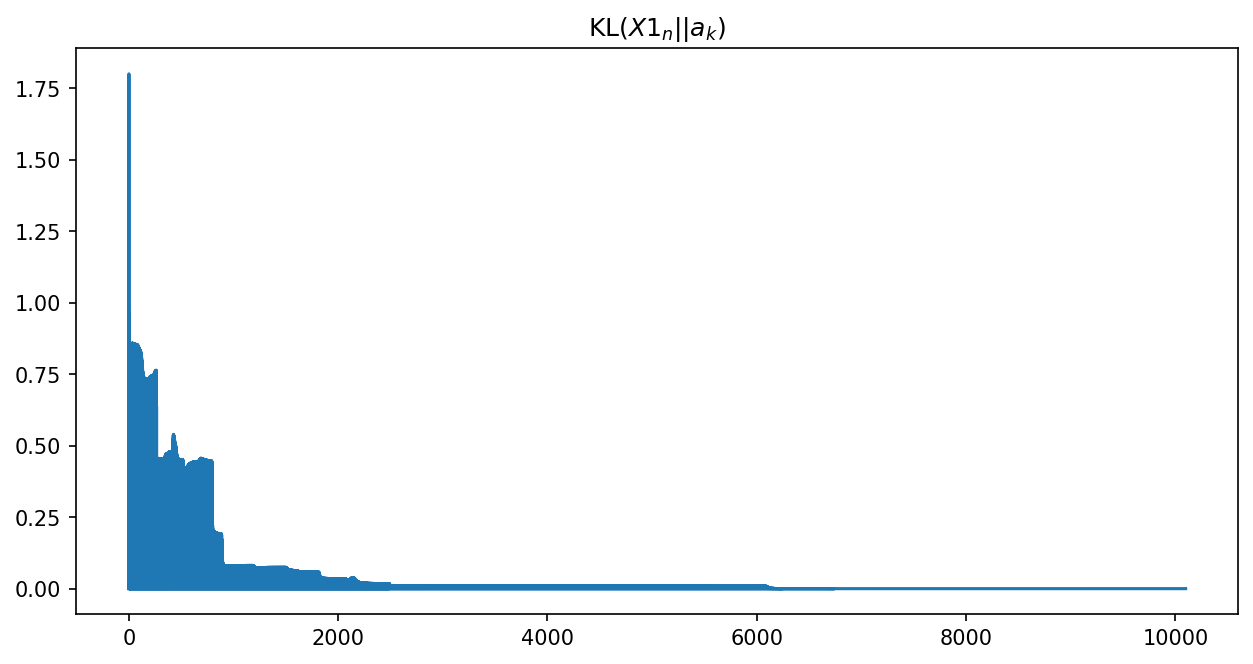

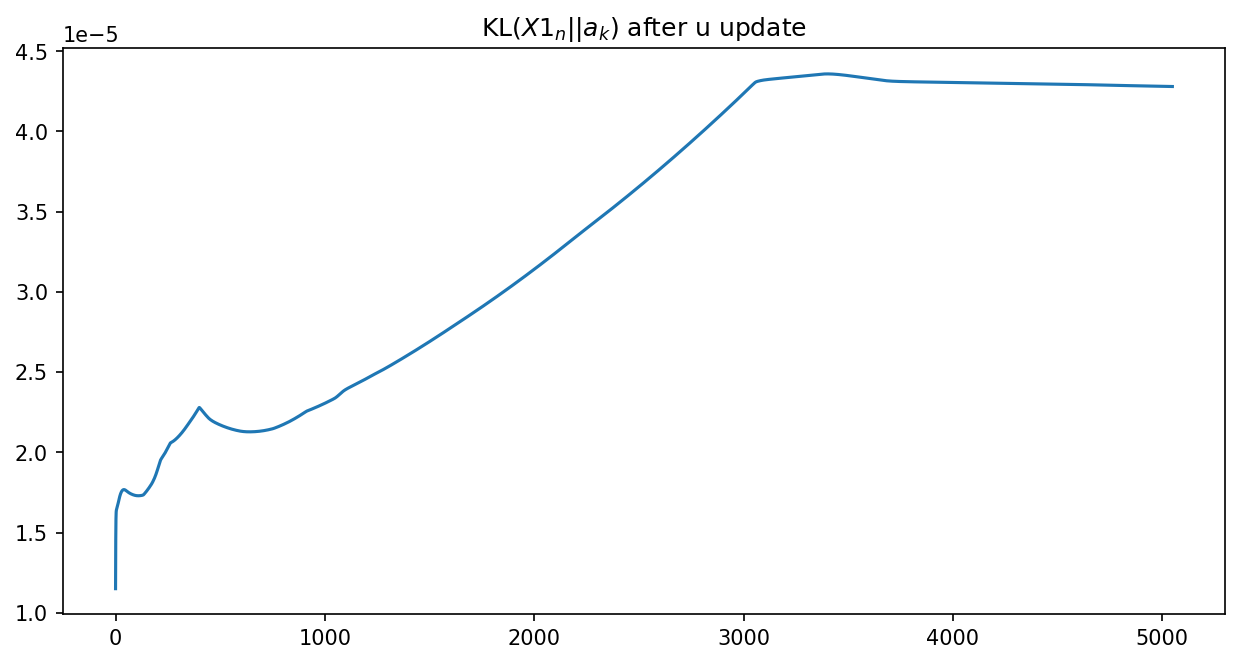

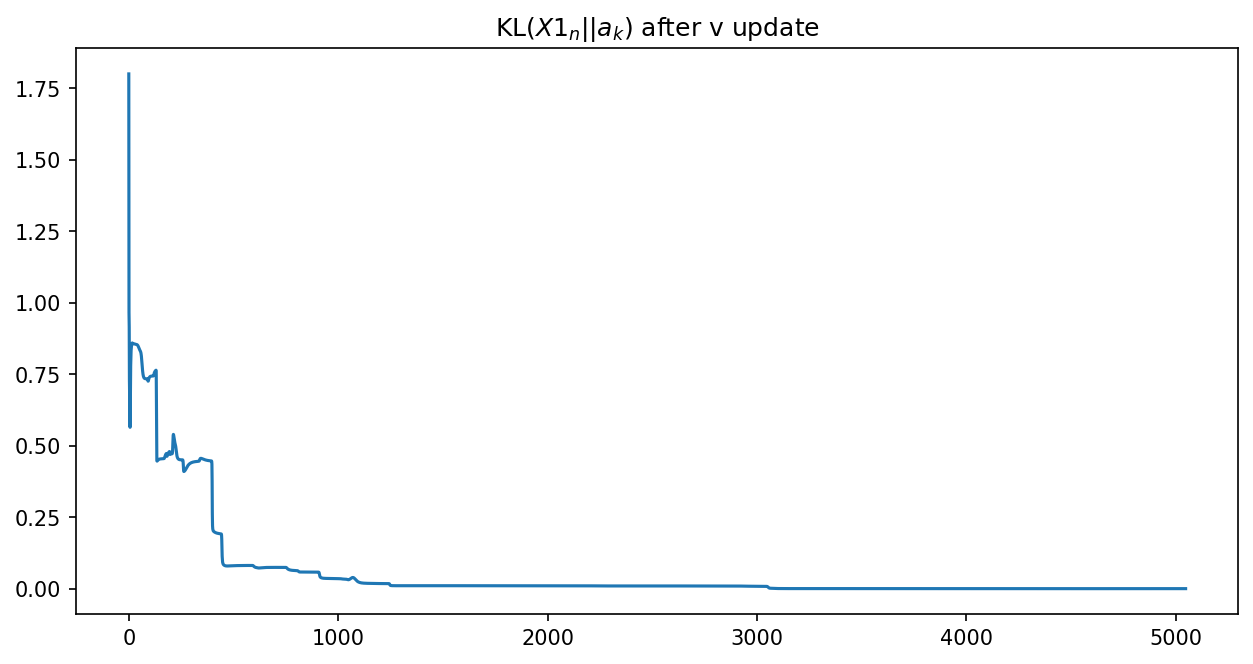

4


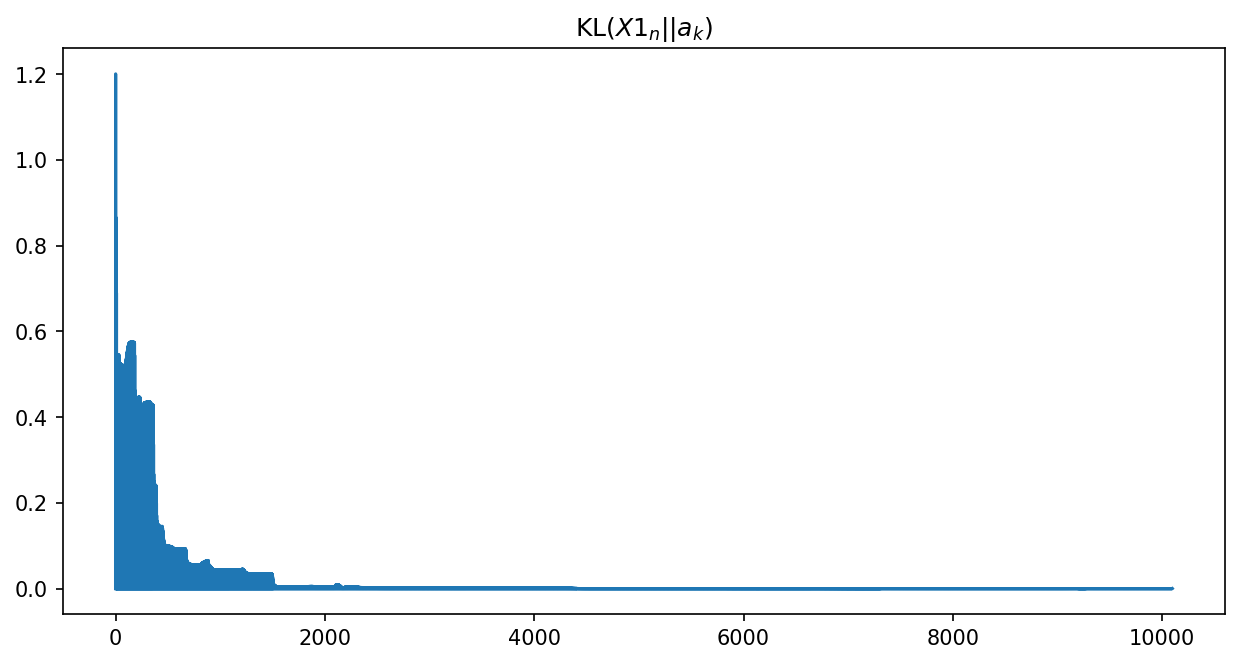

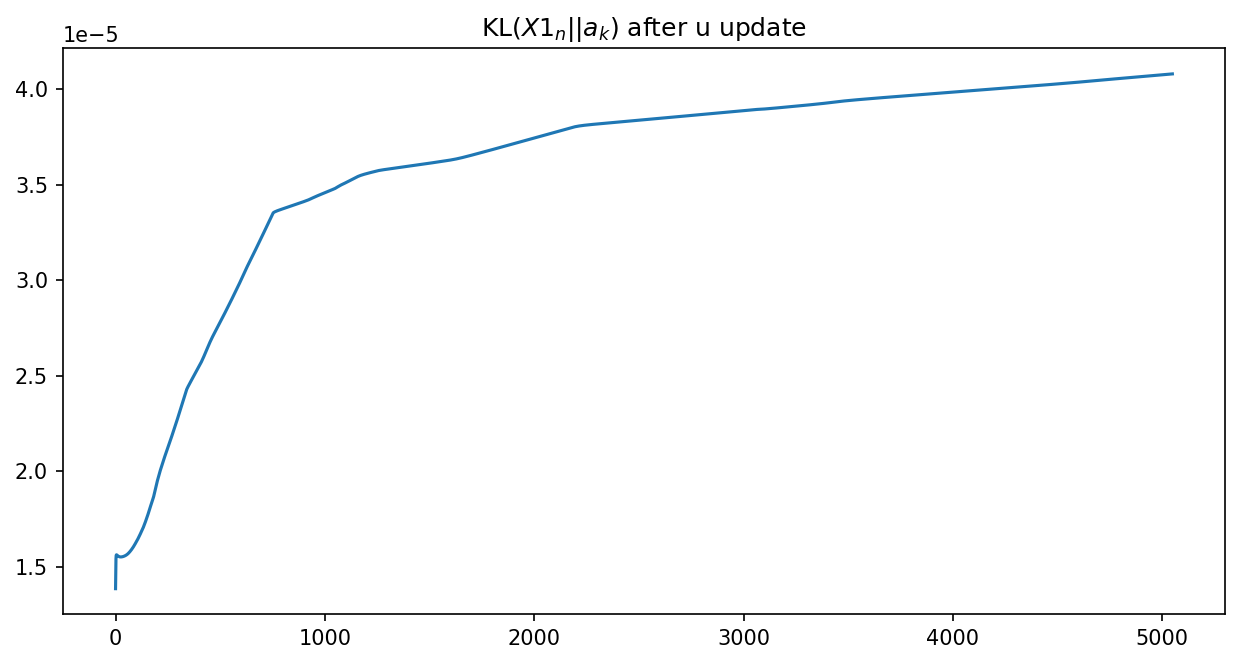

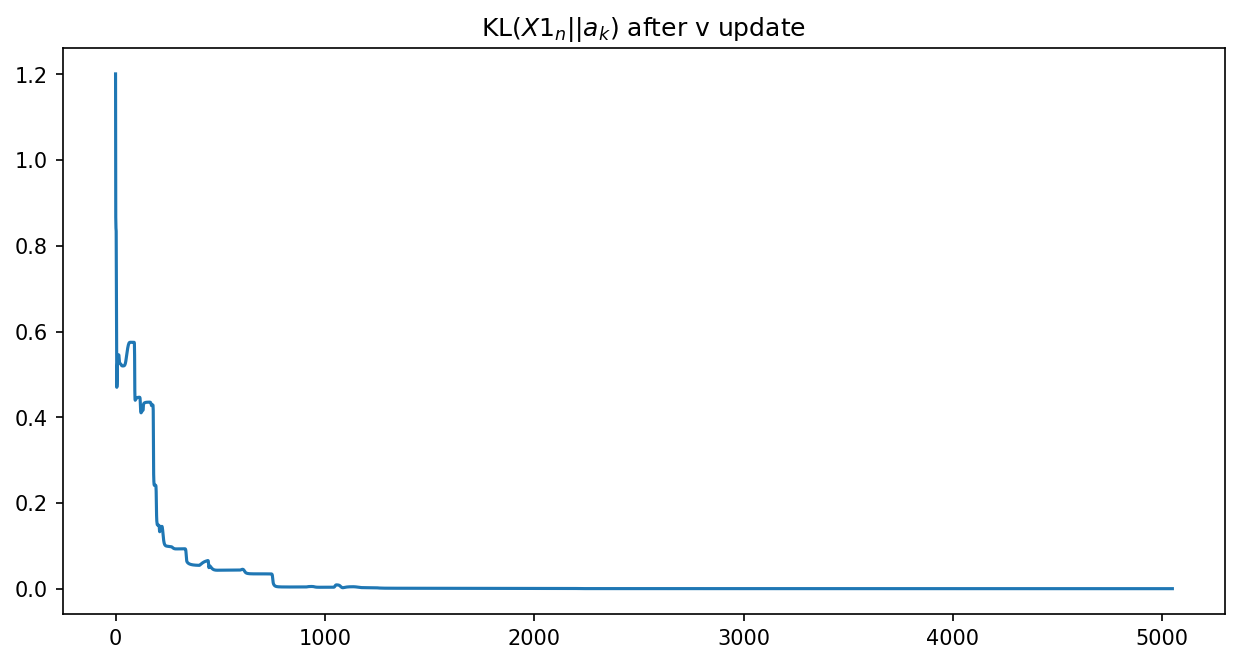

In [21]:
y = [[] for _ in range(ersbp.m)]

for uk, vk in zip(log['u'], log['v']):
    Xk = ersbp.calc_logB(uk, vk)
    Xk = np.exp(Xk - logsumexp(Xk, (1, 2), keepdims=True))

    ak = Xk.sum(2)

    for i in range(ersbp.m):
        y[i].append(calc_KL(ak[i], ersbp.p[i]))

for i in range(ersbp.m):
    print(i)

    # Overview
    plt.figure(figsize=(10, 5), dpi=150)
    plt.plot(y[i][1:])
    plt.title('KL$(X 1_n || a_k)$')
    plt.show()

    # Each u update
    plt.figure(figsize=(10, 5), dpi=150)
    plt.plot(y[i][1::2])
    plt.title('KL$(X 1_n || a_k)$ after u update')
    plt.show()

    # Each v update
    plt.figure(figsize=(10, 5), dpi=150)
    plt.plot(y[i][2::2])
    plt.title('KL$(X 1_n || a_k)$ after v update')
    plt.show()

    print('==============')